In [10]:
import matplotlib.pylab as plt
import numpy as np
from scipy.optimize import curve_fit 
import glob
import os


In [24]:
# uncalibrated files
files = glob.glob('logging/converted/[0-9]*.csv')

In [28]:
pos_mm = np.array([float(".".join(os.path.basename(f).split('_')[:2])) for f in files])

In [46]:
voltage = np.array([np.genfromtxt(f, skip_header= 8, dtype = float, 
                        delimiter = ',').mean(axis = 0)[-1] for f in files])

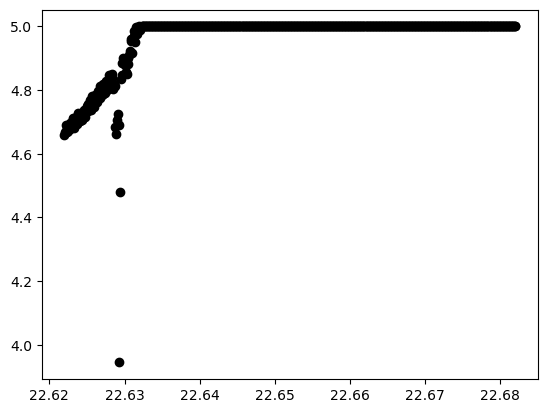

In [48]:
plt.plot(pos_mm, voltage, 'ko')